In [1]:
import vis
from keras import activations
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf 
tf.disable_v2_behavior()
import keras
import numpy as np
import os
import random
from scipy.ndimage import zoom

from keras import backend
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, GlobalAveragePooling2D, Dense, Dropout
from keras.layers import Input, Conv2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import text_to_word_sequence
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.utils import to_categorical

Using TensorFlow backend.
W1208 04:19:40.890829 140187379169024 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/compat/v2_compat.py:61: disable_resource_variables (from tensorflow.python.ops.variable_scope) is deprecated and will be removed in a future version.
Instructions for updating:
non-resource variables are not supported in the long term


In [90]:
def viewSlice(epi_img_data):
    n_i, n_j, n_k = epi_img_data.shape
    center_i = (n_i - 1) // 2  # // for integer division
    center_j = (n_j - 1) // 2
    center_k = (n_k - 1) // 2
    slice_0 = epi_img_data[center_i, :, :]
    slice_1 = epi_img_data[:, center_j, :]
    slice_2 = epi_img_data[:, :, center_k]
    show_slices([slice_0, slice_1, slice_2])
    plt.suptitle("Center slices for EPI image") 
    
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

In [80]:
base_model = ResNet50(weights="imagenet", include_top=False,
              input_tensor=Input(shape=(110, 110, 3))) #192, 192, 3

for layer in base_model.layers:
    layer.trainable = True

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [81]:
# Add layer to change output dims
# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# add a fully-connected layer
x = Dense(1024, activation='sigmoid')(x)
x = Dropout(0.4)(x)
# and a logistic layer -- 3 classes
predictions = Dense(2, activation='softmax')(x) 
model = Model(inputs=base_model.input, outputs=predictions)

In [23]:
def load_dataset(directory):
    print("loading 3 class ADNI with skull dataset")
    patientData = np.loadtxt("ADNI1_Complete_1Yr_1.5T_10_26_2019.csv", 
                         dtype= 'str', skiprows=1, delimiter=',')
    
    integer_mapping = {x: i for i,x in enumerate(['AD', 'MCI', 'CN'])}
    y = np.asarray([integer_mapping[word] for word in patientData[:,1]])
    labels = to_categorical(y, num_classes=3, dtype='float32')
    
    
    
    xdim = 192
    ydim = 192
    zdim = 160
    X = np.zeros((637,xdim,ydim,zdim,1))
    Y = np.zeros((637,3))
    for i, filename in enumerate(os.listdir(directory)):
        if filename[-4:] == ".nii":
            subject = filename[:-4]

            epi_img = nib.load(directory + subject + '.nii')
            # Get voxel array
            epi_img_data = epi_img.get_fdata()
            #Normalize
            v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
            v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
            epi_img_data = (epi_img_data - v_min)/(v_max - v_min)
            n_i, n_j, n_k = epi_img_data.shape

            if (n_i != 192 or n_j != 192 or n_k != 160):
                #epi_img_data = cv2.resize(epi_img_data, (192, 192))
                #epi_img_data = epi_img_data[0:192,0:192,int(n_k/2)-80:int(n_k/2)+80]

                #resampling to make all MRI volumes the same dimensions
                epi_img_data = zoom(epi_img_data, (float(xdim/n_i), float(ydim/n_j), float(zdim/n_k)), order = 0)

            x = epi_img_data

            x = np.expand_dims(x, axis=3)

            X[i] = x

            ind = np.where(patientData[:,0] == subject[:-1])[0][0]
            y = labels[ind, :]
            y = y.reshape(1,-1)

            Y[i] = y

            if i % 50 == 0:
                print ("loaded {} subjects".format(i))
        
    print (X.shape)
    print (Y.shape)
        
    return X, Y

In [26]:
def load_dataset_2classes(directory):
    print("loading 2 class dataset")
    patientData = np.loadtxt("ADNI1_Complete_1Yr_1.5T_10_26_2019.csv", 
                         dtype= 'str', skiprows=1, delimiter=',')
    
    integer_mapping = {x: i for i,x in enumerate(['AD', 'MCI', 'CN'])}
    y_t = np.asarray([integer_mapping[word] for word in patientData[:,1]])
    labels = to_categorical(y_t, num_classes=3, dtype='float32')
    
    
    
    xdim = 192
    ydim = 192
    zdim = 160
    X = np.zeros((637,xdim,ydim,zdim,1))
    Y = np.zeros((637,2))
    y_single = np.zeros((637,1))
    for i, filename in enumerate(os.listdir(directory)):
        if filename[-4:] == ".nii":
            subject = filename[:-4]

            epi_img = nib.load(directory + subject + '.nii')
            # Get voxel array
            epi_img_data = epi_img.get_fdata()
            #Normalize
            v_min = epi_img_data.min(axis=(0, 1, 2), keepdims=True)
            v_max = epi_img_data.max(axis=(0, 1, 2), keepdims=True)
            epi_img_data = (epi_img_data - v_min)/(v_max - v_min)
            n_i, n_j, n_k = epi_img_data.shape

            if (n_i != 192 or n_j != 192 or n_k != 160):
                #epi_img_data = cv2.resize(epi_img_data, (192, 192))
                #epi_img_data = epi_img_data[0:192,0:192,int(n_k/2)-80:int(n_k/2)+80]

                #resampling to make all MRI volumes the same dimensions
                epi_img_data = zoom(epi_img_data, (float(xdim/n_i), float(ydim/n_j), float(zdim/n_k)), order = 0)

            x = epi_img_data

            x = np.expand_dims(x, axis=3)

            X[i] = x

            ind = np.where(patientData[:,0] == subject[:-1])[0][0]
            y = labels[ind, :]
            y = y.reshape(1,-1)
            
            if y[0][1] == 1: # remove MCI
                y[0][2] = 1
            y = np.delete(y,1,1)

            Y[i] = y
            y_single[i] = np.array([y_t[ind]])

            if i % 50 == 0:
                print ("loaded {} subjects".format(i))
        
    print (X.shape)
    print (Y.shape)
        
    return X, Y, y_single

In [3]:
def load_dataset_clean():
    print("loading prepocessed - skull stripped dataset")
    AD_directory = "/home/ubuntu/project/Data/AD_clean/"
    NC_directory = "/home/ubuntu/project/Data/NC_clean/"
    
    AD_list = os.listdir(AD_directory)
    NC_list = os.listdir(NC_directory)
    

    All_directory = "/home/ubuntu/project/Data/AD_NC_Clean/"
    img_size_x = 110
    img_size_y = 110
    img_size_z = 110
    X = np.zeros((111,img_size_x,img_size_y,img_size_z,1))
    Y = np.zeros(111)
    y_wider = np.zeros((111,2))
    
    l = os.listdir(All_directory)
    random.shuffle(l)
   
    
    objindex = 0
    for i, filename in enumerate(l):
        if (filename.startswith('.')):
            print ("hidden file")
        else:
            epi_img = nib.load(All_directory + filename)
            x = epi_img.get_fdata()
            x = (x-x.min())/x.max()
            
            x = np.expand_dims(x, axis=3)
            X[objindex] = x
            y = 0
            if filename in AD_list:
                y = 1
                y_wider[i,0] = 1
            else:
                y_wider[i,1] = 1
                
            Y[objindex] = y
            
            objindex += 1
            
    return X, y_wider, Y

In [86]:
X,Y, y = load_dataset_clean() # 2classes("Data/CombinedClean/")
print(Y.shape)
print(X.shape)
print(y.shape)

loading prepocessed - skull stripped dataset
(111, 2)
(111, 110, 110, 110, 1)
(111,)


In [87]:
X_new = np.repeat(np.expand_dims(X[:,:,:,80],axis=3),3,axis=3)#np.squeeze(X, axis = 4)
X_new = np.squeeze(X,axis=4)


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=42)
#viewSlice(np.squeeze(X, axis = 4)[100,:,:,:])
print(X_train.shape)

(88, 110, 110, 110)


(88, 110, 110, 3)
(88, 110, 110, 3)
(110, 110)


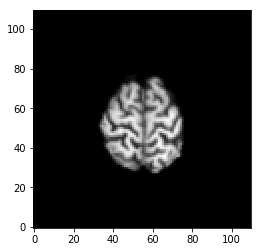

In [5]:
# input single slice only 2 = 3rd slice
X_train_single = np.repeat(np.expand_dims(X_train[:,:,:,2],axis=3), 3, axis=3)
X_test_single = np.repeat(np.expand_dims(X_test[:,:,:,2],axis=3), 3, axis=3)
print(X_train_single.shape)
print(X_test_single[0,:,:,2].shape)
plt.imshow(X_test_single[0,:,:,2].T, cmap="gray", origin="lower")

In [103]:
import matplotlib.pyplot as plt
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

X_flat = X[:,:,:,1].reshape(X.shape[0], -1)
print(X_flat.shape)
print(y.shape)
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.3, shuffle=True)

SVM = svm.SVC(gamma=0.001)
lower = np.random.randint(low=0,high=X_train.shape[1])
print("rand: ",lower)
SVM.fit(X_train[:,lower:lower+2], y_train)
predicted = SVM.predict(X_test[:,:2])

(111, 12100)
(111,)
rand:  6747


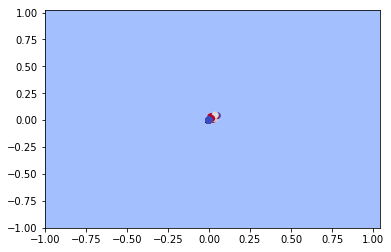

In [38]:
# create a mesh to plot in
h = .02  
x_min, x_max = X_flat[:, 0].min() - 1, X_flat[:, 0].max() + 1
y_min, y_max = X_flat[:, 1].min() - 1, X_flat[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = SVM.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(X_flat[:, lower], X_flat[:, lower+1], c=y.reshape(-1), cmap=plt.cm.coolwarm)
plt.show()

In [41]:
#Train on all features
SVM.fit(X_train, y_train)
predicted = SVM.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (SVM, metrics.classification_report(y_test, predicted)))
print(predicted)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        48
         1.0       0.45      1.00      0.62        87
         2.0       0.00      0.00      0.00        57

    accuracy                           0.45       192
   macro avg       0.15      0.33      0.21       192
weighted avg       0.21      0.45      0.28       192


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [116]:
datagen = ImageDataGenerator(featurewise_center=True, samplewise_center=True, featurewise_std_normalization=True, 
                             samplewise_std_normalization=True, zca_whitening=False, zca_epsilon=1e-06, rotation_range=180, 
                             width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, 
                             zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, 
                             vertical_flip=False,rescale=None, preprocessing_function=None, data_format='channels_last', 
                             validation_split=0.1)
it = datagen.flow(X_train_single, y_train)

In [117]:
# categorical
from keras import optimizers
adam = optimizers.Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [120]:
#X = preprocess_input(X)
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=30, batch_size=2, verbose = 2, validation_split = 0.1, shuffle=True)
#history = model.fit_generator(it, epochs=100, steps_per_epoch=100)

Train on 79 samples, validate on 9 samples
Epoch 1/30
 - 5s - loss: 0.0129 - acc: 0.9873 - val_loss: 0.0650 - val_acc: 1.0000
Epoch 2/30
 - 5s - loss: 1.0845e-04 - acc: 1.0000 - val_loss: 0.0833 - val_acc: 1.0000
Epoch 3/30
 - 5s - loss: 8.1099e-05 - acc: 1.0000 - val_loss: 0.1062 - val_acc: 1.0000
Epoch 4/30
 - 5s - loss: 2.2602e-04 - acc: 1.0000 - val_loss: 0.1469 - val_acc: 0.8889
Epoch 5/30
 - 5s - loss: 3.1008e-04 - acc: 1.0000 - val_loss: 0.1642 - val_acc: 0.8889
Epoch 6/30
 - 5s - loss: 8.2264e-05 - acc: 1.0000 - val_loss: 0.2055 - val_acc: 0.8889
Epoch 7/30
 - 5s - loss: 1.0150e-04 - acc: 1.0000 - val_loss: 0.1702 - val_acc: 0.8889
Epoch 8/30
 - 5s - loss: 1.3371e-04 - acc: 1.0000 - val_loss: 0.2285 - val_acc: 0.8889
Epoch 9/30
 - 5s - loss: 1.3460e-04 - acc: 1.0000 - val_loss: 0.2106 - val_acc: 0.8889
Epoch 10/30
 - 5s - loss: 1.2784e-04 - acc: 1.0000 - val_loss: 0.1992 - val_acc: 0.8889
Epoch 11/30
 - 5s - loss: 1.2732e-04 - acc: 1.0000 - val_loss: 0.2129 - val_acc: 0.8889
Ep

In [6]:
#model.save('TransferLearning_2classes_30epochs_SkullStrippedData_slice2.h5')
from keras.models import load_model
model = load_model('TransferLearning_2classes_30epochs_SkullStrippedData_slice2.h5')

W1208 04:19:55.873525 140187379169024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1208 04:19:55.916844 140187379169024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W1208 04:19:55.942512 140187379169024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:245: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1208 04:19:55.943329 140187379169024 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.p

In [108]:
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay

model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

In [109]:
print(y_train[50,:])

[1. 0.]


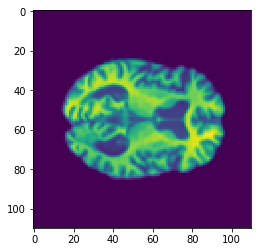

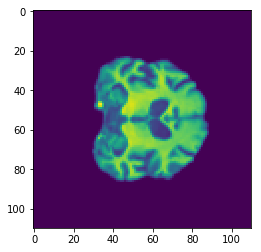

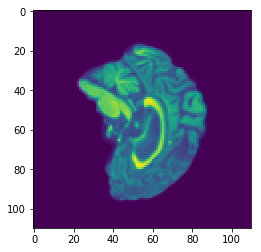

In [100]:
# img = X_train_single[50,:,:,2]
# plt.imshow(img)
# plt.savefig('mri1.jpg')

X_s2 = np.repeat(np.expand_dims(X[:,:,:,55],axis=3),3,axis=3)#np.squeeze(X, axis = 4)
X_s2 = np.squeeze(X_s2,axis=4)
X_train_s2, X_test_s2, y_train_s2, y_test_s2 = train_test_split(X_s2, Y, test_size=0.2, random_state=42)
plt.figure()
plt.imshow(X_train_s2[50,:,:,0])

X_s1 = np.repeat(np.expand_dims(X[:,:,55,:],axis=3),3,axis=3)#np.squeeze(X, axis = 4)
X_s1 = np.squeeze(X_s1,axis=4)
X_train_s1, X_test_s1, y_train_s1, y_test_s1 = train_test_split(X_s1, Y, test_size=0.2, random_state=42)
plt.figure()
plt.imshow(X_train_s1[50,:,:,0])

X_s3 = np.repeat(np.expand_dims(X[:,55,:,:],axis=3),3,axis=3)#np.squeeze(X, axis = 4)
X_s3 = np.squeeze(X_s3,axis=4)
X_train_s3, X_test_s3, y_train_s3, y_test_s3 = train_test_split(X_s3, Y, test_size=0.2, random_state=42)
plt.figure()
plt.imshow(X_train_s3[50,:,:,0])

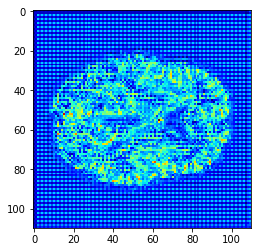

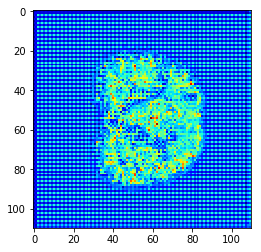

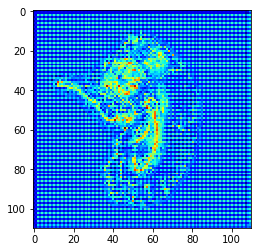

In [103]:
#img_new = utils.load_img('../project/mri1.jpg')
i = 5
img2 = X_train_s2[30,:,:,:]    
grads = visualize_saliency(model, layer_idx=i, filter_indices=None, seed_input=img2)
plt.figure()
plt.imshow(grads, cmap='jet')

img1 = X_train_s1[30,:,:,:]    
grads = visualize_saliency(model, layer_idx=i, filter_indices=None, seed_input=img1)
plt.figure()
plt.imshow(grads, cmap='jet')

img3 = X_train_s3[30,:,:,:] 
grads = visualize_saliency(model, layer_idx=i, filter_indices=None, seed_input=img3)
plt.figure()
plt.imshow(grads, cmap='jet')


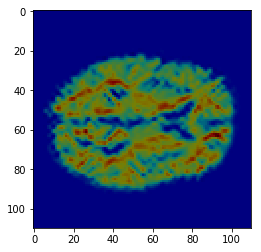

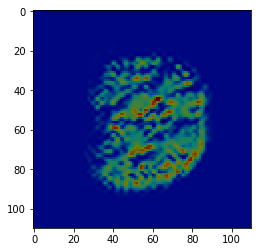

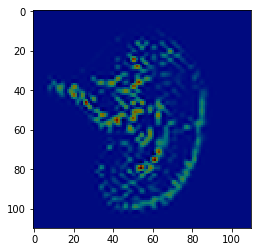

In [106]:
from vis.visualization import visualize_cam
import matplotlib.cm as cm

i = 5
grads = visualize_cam(model, layer_idx=i, filter_indices=None, 
                      seed_input=img2, penultimate_layer_idx=None,
                      backprop_modifier=None)            
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
plt.figure()
plt.imshow(overlay(jet_heatmap, img))

grads = visualize_cam(model, layer_idx=i, filter_indices=None, 
                      seed_input=img1, penultimate_layer_idx=None,
                      backprop_modifier=None)            
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
plt.figure()
plt.imshow(overlay(jet_heatmap, img))

grads = visualize_cam(model, layer_idx=i, filter_indices=None, 
                      seed_input=img3, penultimate_layer_idx=None,
                      backprop_modifier=None)            
jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 255)
plt.figure()
plt.imshow(overlay(jet_heatmap, img))

In [41]:
from sklearn.metrics import classification_report, f1_score
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()

_, accuracy = model.evaluate(X_test_single, y_test)
print('Accuracy: %.2f' % (accuracy*100))
preds = model.predict(X_test_single)
#print(np.round(preds))

print(classification_report(lb.fit_transform(y_test[:,0]), lb.fit_transform(np.round(preds[:,0]))))
print(f1_score(lb.fit_transform(y_test[:,0]), lb.fit_transform(np.round(preds[:,0]))))

23/23 [==============================] - 5s 220ms/step
Accuracy: 95.65


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

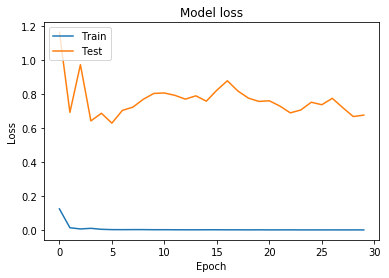

In [104]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

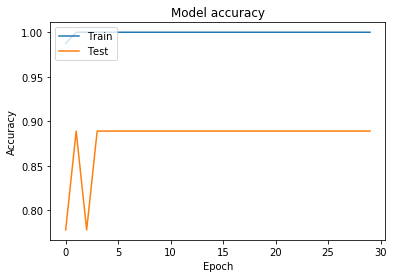

In [107]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [108]:
#SVM on skullstripped data
SVM.fit(X_train,y_train)
predicted = SVM.predict(X_test)
print("Classification report for classifier %s:\n%s\n"
      % (SVM, metrics.classification_report(y_test, predicted)))
print(predicted)

Classification report for classifier SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False):
              precision    recall  f1-score   support

         0.0       0.62      1.00      0.76        21
         1.0       0.00      0.00      0.00        13

    accuracy                           0.62        34
   macro avg       0.31      0.50      0.38        34
weighted avg       0.38      0.62      0.47        34


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [126]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
np.random.seed(1000)

#Instantiate an empty model
model = Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(110,110,3), kernel_size=(4,4), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(4,4), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(Activation('relu'))

# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(2,2), strides=(1,1), padding='valid'))
model.add(Activation('relu'))
# Max Pooling
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))

# Passing it to a Fully Connected layer
model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(4096, input_shape=(192*192*3,)))
model.add(Activation('relu'))
# Add Dropout to prevent overfitting
model.add(Dropout(0.4))

# 2nd Fully Connected Layer
model.add(Dense(4096))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# 3rd Fully Connected Layer
model.add(Dense(1000))
model.add(Activation('relu'))
# Add Dropout
model.add(Dropout(0.4))

# Output Layer
model.add(Dense(2))
model.add(Activation('softmax'))

model.summary()
opt = optimizers.Adam(lr=0.0000005, beta_1=0.9, beta_2=0.999, amsgrad=False)

# Compile the model
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"]) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 27, 27, 96)        4704      
_________________________________________________________________
activation_164 (Activation)  (None, 27, 27, 96)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 13, 13, 96)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 10, 10, 256)       393472    
_________________________________________________________________
activation_165 (Activation)  (None, 10, 10, 256)       0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 4, 4, 384)         393600    
__________

In [127]:
history = model.fit(X_train, y_train, epochs=30, batch_size=2, verbose = 2, validation_split = 0.1, shuffle=True)

Train on 79 samples, validate on 9 samples
Epoch 1/30
 - 20s - loss: 0.6940 - acc: 0.4304 - val_loss: 0.6921 - val_acc: 0.7778
Epoch 2/30
 - 2s - loss: 0.6939 - acc: 0.4304 - val_loss: 0.6918 - val_acc: 0.7778
Epoch 3/30
 - 2s - loss: 0.6936 - acc: 0.4684 - val_loss: 0.6917 - val_acc: 0.7778
Epoch 4/30
 - 2s - loss: 0.6926 - acc: 0.4684 - val_loss: 0.6915 - val_acc: 0.7778
Epoch 5/30
 - 2s - loss: 0.6932 - acc: 0.4937 - val_loss: 0.6914 - val_acc: 0.7778
Epoch 6/30
 - 2s - loss: 0.6926 - acc: 0.5190 - val_loss: 0.6913 - val_acc: 0.7778
Epoch 7/30
 - 2s - loss: 0.6929 - acc: 0.4557 - val_loss: 0.6911 - val_acc: 0.7778
Epoch 8/30
 - 2s - loss: 0.6936 - acc: 0.4937 - val_loss: 0.6908 - val_acc: 0.7778
Epoch 9/30
 - 2s - loss: 0.6931 - acc: 0.5443 - val_loss: 0.6908 - val_acc: 0.7778
Epoch 10/30
 - 2s - loss: 0.6932 - acc: 0.5316 - val_loss: 0.6906 - val_acc: 0.7778
Epoch 11/30
 - 2s - loss: 0.6921 - acc: 0.6076 - val_loss: 0.6903 - val_acc: 0.7778
Epoch 12/30
 - 2s - loss: 0.6922 - acc: 0

In [ ]:
_, accuracy = model.evaluate(X_test, y_test)
print('Accuracy: %.2f' % (accuracy*100))